As we get started, let's make sure we've got some key Python modules installed...

In [1]:
!pip3 -q install sklearn pandas seaborn
!pip3 -q install 'keras==2.0.6' --force-reinstall

import pandas as pd
import sklearn
import keras
print("keras version {} installed".format(keras.__version__))
print("pandas version {} installed".format(pd.__version__))
print("scikit-learn version {} installed".format(sklearn.__version__))

Using TensorFlow backend.


keras version 2.0.6 installed
pandas version 0.19.2 installed
scikit-learn version 0.18.1 installed


Now let's import some utility code that will read a subset of the columns from our cleaned data file into a [Pandas](http://pandas.pydata.org/) data frame.   We'll review the data we've loaded using the [DataFrame.info()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html) method.

In [2]:
# Import pandas 
import train_util as util

helper = util.LendingClubModelHelper()

# Read in lending club data 
helper.read_csv("lc-2015-loans.csv", 
                util.APPLICANT_NUMERIC +
                util.APPLICANT_CATEGORICAL +
                util.CREDIT_NUMERIC +
                util.LABEL)


print(helper.lcdata.info(null_counts = True, memory_usage = "deep", verbose = True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 50 columns):
loan_amnt                     421095 non-null int64
term                          421095 non-null object
installment                   421095 non-null float64
grade                         421095 non-null category
emp_length                    421095 non-null object
home_ownership                421095 non-null object
annual_inc                    421095 non-null float64
addr_state                    421095 non-null object
dti                           421095 non-null float64
delinq_2yrs                   421095 non-null int64
fico_range_low                421095 non-null int64
fico_range_high               421095 non-null int64
open_acc                      421095 non-null int64
pub_rec                       421095 non-null int64
revol_bal                     421095 non-null int64
revol_util                    421095 non-null float64
total_acc                     421095 non-n

Now we can do some quick exploration of the data.  We'll start by looking at a correlation matrix helping us visually see which features in the dataset seem to be related or unrelated.

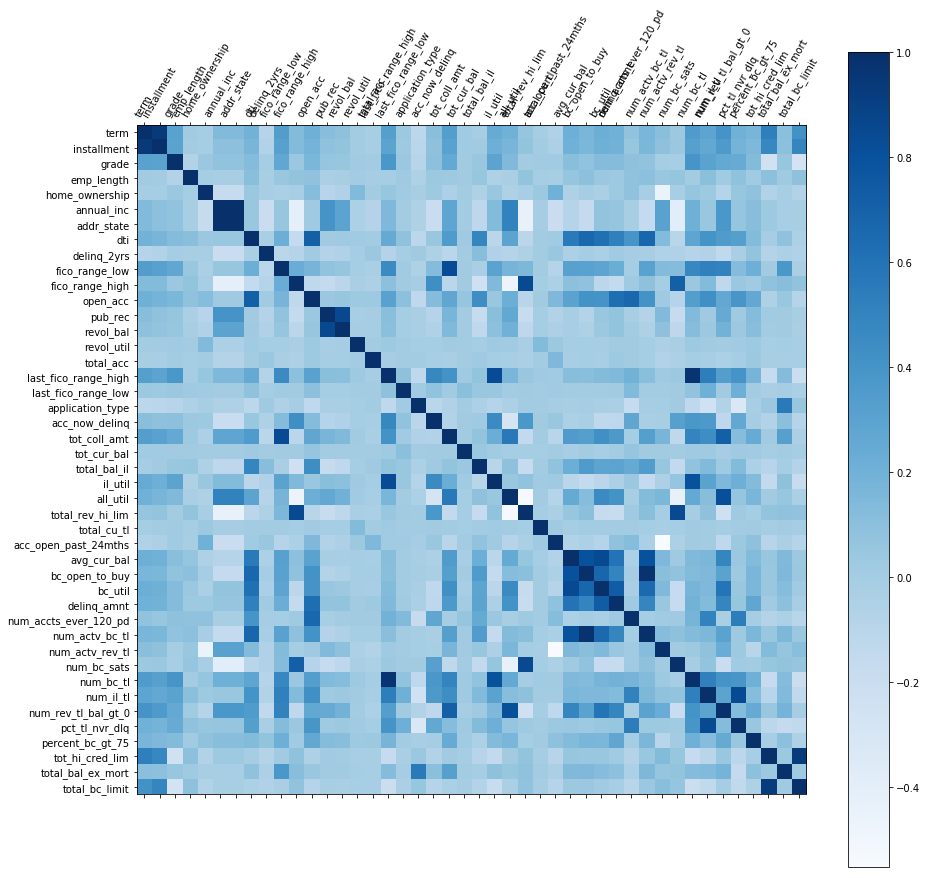

In [3]:
%matplotlib inline

import plot_util as plots

# Show a correlation matrix of the features in our data set
plots.plot_correlation_matrix(helper.lcdata)

Next we can take a look at the distribution of some values by loan grade for some features of interest using "violin" charts.  The distribution of the FICO scores look about as expected with the A grade loans having higher values than the G grade loans.   There is an interesting trend of more jittery distribution of accounts opened in the past 24 months for higher grade loans relative to the lower grade loans.

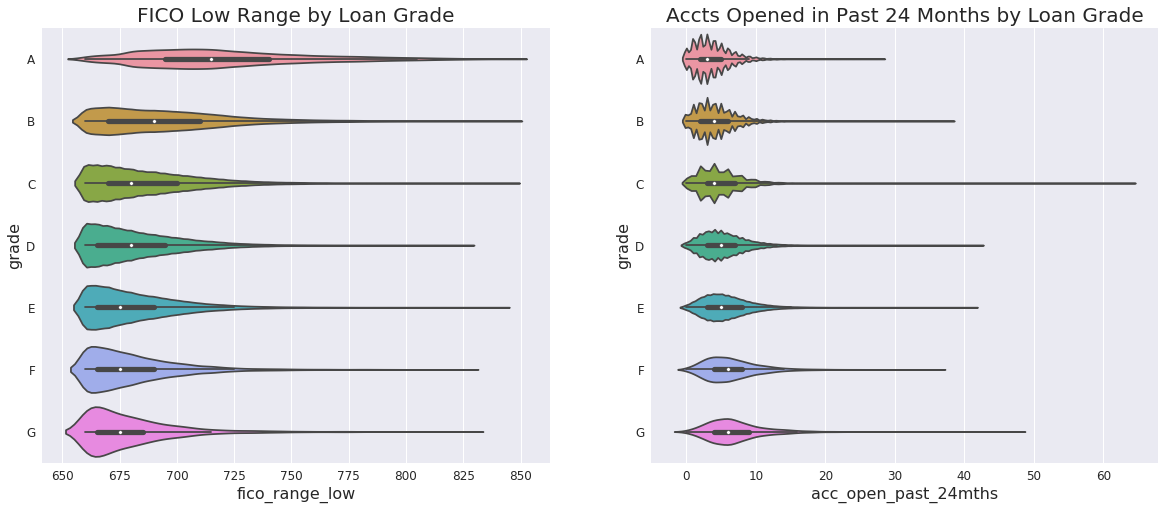

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

# Create violinplot
plt.subplot(121)
v1 = sns.violinplot(x = "fico_range_low", y="grade", data=helper.lcdata)
v1.axes.set_title("FICO Low Range by Loan Grade", fontsize=20)

plt.subplot(122)
v2 = sns.violinplot(x = "acc_open_past_24mths", y="grade", data=helper.lcdata)
v2.axes.set_title("Accts Opened in Past 24 Months by Loan Grade", fontsize=20)

# Show the plot
plt.show()

Here we can take a look at the annual income and average current credit balance by loan grade.

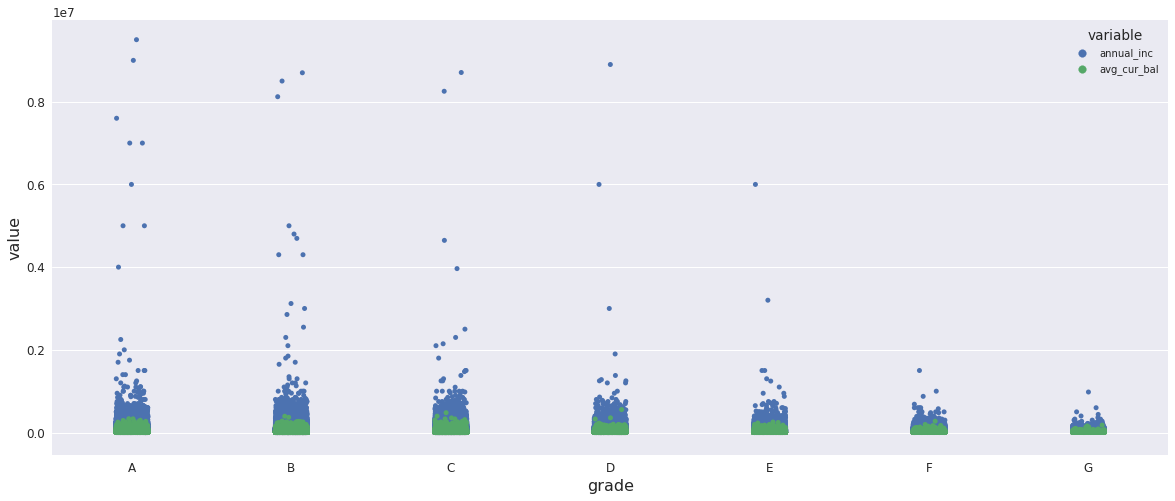

In [5]:
melted = pd.melt(helper.lcdata, id_vars = ["grade"], value_vars=["annual_inc", "avg_cur_bal"])

# We unfortunately lose our categorical ordering with the pd.melt() call and need to add it back
melted["grade"] = melted["grade"].astype("category", categories=["A", "B", "C", "D", "E", "F", "G"], ordered=True)

sns.stripplot(x="grade", y="value", hue="variable", data=melted, jitter = True);

Now we'll move on to preparing to train a machine learning model on the data.  We're going to first split the data by column into "X" the data that will be fed into the model as input and "Y" the single column of data we're trying to predict: loan grade.

Then we'll split the data by row; 80% will be used to train/validate the model and 20% will be used to test how well the model performs on unseen data.

Note that the loan grade has been one-hot encoded.

In [9]:
import os

# Divide the data set into training and test sets
helper.split_data(util.APPLICANT_NUMERIC + util.CREDIT_NUMERIC,
                  util.APPLICANT_CATEGORICAL,
                  util.LABEL,
                  test_size = 0.2,
                  row_limit = os.environ.get("sample"))

# Inspect our training data
print("x_train contains {} rows and {} features".format(helper.x_train.shape[0], helper.x_train.shape[1]))
print("y_train contains {} rows and {} features".format(helper.y_train.shape[0], helper.y_train.shape[1]))

print("x_test contains {} rows and {} features".format(helper.x_test.shape[0], helper.x_test.shape[1]))
print("y_test contains {} rows and {} features".format(helper.y_test.shape[0], helper.y_test.shape[1]))

# Loan grade has been one-hot encoded
print("Sample one-hot encoded 'y' value: \n{}".format(helper.y_train.sample()))

AttributeError: 'NoneType' object has no attribute 'summary'

Our Keras model is not terribly complex.  It take in the 112 columns of data, feeds them to a hidden layer of 100 nodes.  The first hidden layer feeds to a second hidden layer of 60 nodes and finally we have 7 nodes for each of our possible loan grades in the output layer.

The [Dropout](https://keras.io/layers/core/#dropout) layers are added to help prevent the model from overfitting to the training data.

In [10]:
# %load model_definition.py
"""Create Keras model"""

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm

def create_model(input_dim, output_dim):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(100, input_dim=input_dim, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # hidden layer
    model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # output layer
    model.add(Dense(output_dim, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Now we'll proceed with training the model.  We've defined the **structure** of the model but training will determine the **parameters at each node** in each layer through a process of optimizing to get minimal error in predictions.

In [11]:
from model_definition import create_model

history = helper.train_model(create_model)

print(helper.model.summary())

Beginning model training with batch size 64 and 45 epochs
Train on 32000 samples, validate on 8000 samples
Epoch 1/45
1s - loss: 1.3813 - acc: 0.4094 - val_loss: 1.2350 - val_acc: 0.4705
Epoch 2/45
1s - loss: 1.2138 - acc: 0.4693 - val_loss: 1.1105 - val_acc: 0.5165
Epoch 3/45
1s - loss: 1.0971 - acc: 0.5182 - val_loss: 0.9525 - val_acc: 0.6012
Epoch 4/45
1s - loss: 0.9715 - acc: 0.5748 - val_loss: 0.8203 - val_acc: 0.6506
Epoch 5/45
1s - loss: 0.8516 - acc: 0.6301 - val_loss: 0.6825 - val_acc: 0.7221
Epoch 6/45
1s - loss: 0.7563 - acc: 0.6731 - val_loss: 0.6040 - val_acc: 0.7508
Epoch 7/45
1s - loss: 0.6849 - acc: 0.7076 - val_loss: 0.5516 - val_acc: 0.7831
Epoch 8/45
1s - loss: 0.6308 - acc: 0.7310 - val_loss: 0.5054 - val_acc: 0.7926
Epoch 9/45
1s - loss: 0.5904 - acc: 0.7468 - val_loss: 0.4697 - val_acc: 0.8186
Epoch 10/45
1s - loss: 0.5581 - acc: 0.7622 - val_loss: 0.4257 - val_acc: 0.8317
Epoch 11/45
1s - loss: 0.5313 - acc: 0.7747 - val_loss: 0.4147 - val_acc: 0.8373
Epoch 12/45

Graphing the change in model accuracy and loss with each training cycle or "epoch" helps us determine how many epochs make sense.   When the lines start to level off we're not improving the model much with additional epochs.

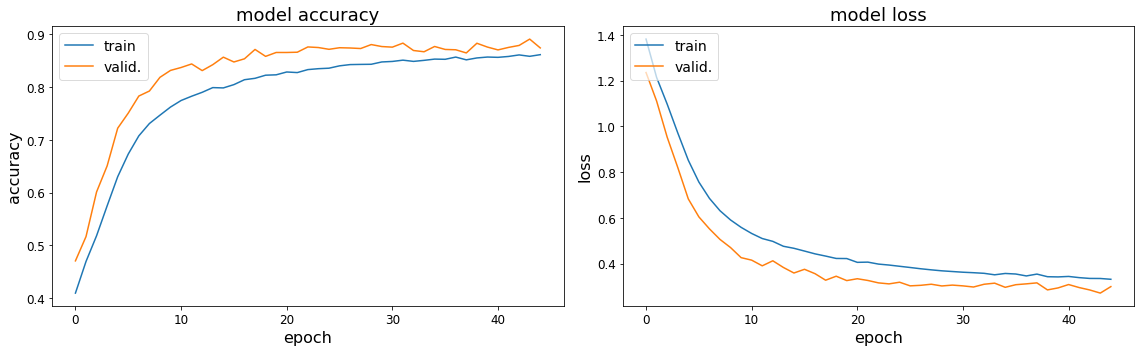

In [12]:
sns.reset_orig()

plots.plot_history(history)

With our trained model we can now see how it performs on the "test" data that we held out of the training data.   We measure the performance using the [F1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

y_pred = helper.model.predict(helper.x_test.as_matrix())

# Revert one-hot encoding to classes
y_pred_classes = pd.DataFrame((y_pred.argmax(1)[:,None] == np.arange(y_pred.shape[1])),
                              columns=helper.y_test.columns,
                              index=helper.y_test.index)

y_test_vals = helper.y_test.idxmax(1)
y_pred_vals = y_pred_classes.idxmax(1)

# F1 score
# Use idxmax() to convert back from one-hot encoding
f1 = f1_score(y_test_vals, y_pred_vals, average='weighted')
print("Test Set Accuracy: {:.2%}".format(f1))



Test Set Accuracy: 87.05%


Finally, since we were looking to predict a categorical variable, we can use a confusion matrix to visualize how the model did predicting each loan grade.

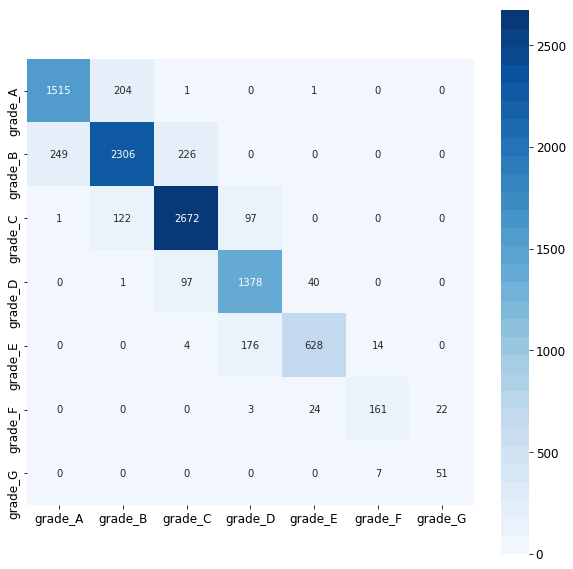

In [14]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cfn_matrix = confusion_matrix(y_test_vals, y_pred_vals)
cfn_frame = pd.DataFrame(cfn_matrix, index=helper.y_test.columns, columns=helper.y_test.columns)

plt.figure(figsize=(10, 10))
sns.heatmap(cfn_frame, square=True, cmap=sns.color_palette("Blues", 30), annot=cfn_matrix, fmt='g')